## Explanation about DQN
https://medium.com/@gtnjuvin/my-journey-into-deep-q-learning-with-keras-and-gym-3e779cc12762

## Setup

In [ ]:
!sudo apt-get install -y xvfb ffmpeg x11-utils
!pip install gym[box2d] 
!pip3 install box2d-py
!pip3 install gym[Box_2D]
!pip install -q 'imageio==2.4.0'
!pip install -q PILLOW
!pip install -q 'pyglet==1.3.2'
!pip install -q pyvirtualdisplay
!pip install -q tf-agents

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils xvfb
0 upgraded, 3 newly installed, 0 to remove and 40 not upgraded.
Need to get 994 kB of archives.
After this operation, 2,981 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.9 [784 kB]
Fetched 994 kB in 1s (1,144 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 3.)
debconf: falling back t

In [ ]:
!pip install colabgymrender

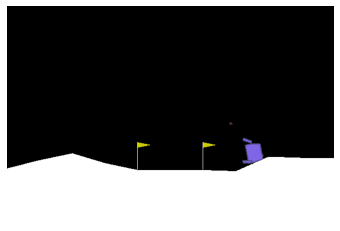

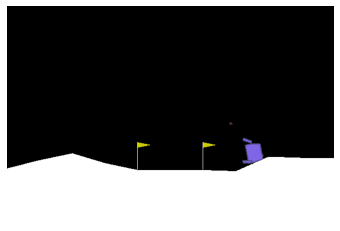

In [ ]:
import gym
from IPython import display
from pyvirtualdisplay import Display
import matplotlib.pyplot as plt
import time
import numpy as np
import gym
from gym import wrappers
from colabgymrender.recorder import Recorder
from matplotlib import pyplot as plt

d = Display()
d.start()

game_name = "LunarLander-v2" # discrete
env = gym.make(game_name)
directory = './video'

env = Recorder(env, directory, fps = 3)
state = env.reset()

img = plt.imshow(env.render('rgb_array'))

episode = 0
while episode < 2:
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)
    
    # FOR DEBUG
    # print(f"action: {action}")
    # print(len(action))
    # print(f"state: {state}")
    # print(f"reward: {reward}")
    # print(f"done: {done}")
    # print(f"info: {info}")
    
    display.clear_output(wait=True)
    img.set_data(env.render('rgb_array'))
    plt.axis('off')
    display.display(plt.gcf())
    # time.sleep(1)
    if done:
      episode += 1
      env.reset()


The Discrete space allows a fixed range of non-negative numbers, so in this case valid actions are either 0 or 1. 

The Box space represents an n-dimensional box, so valid observations will be an array of 4 numbers. 

We can also check the Box’s bounds:

In [ ]:
print(env.action_space)
print(env.observation_space)

Discrete(4)
Box(-inf, inf, (8,), float32)


In [ ]:
from keras.layers import Dense, Activation
from keras.models import Sequential, load_model
from keras.optimizers import Adam
import numpy as np

class ReplayBuffer(object):
    def __init__(self, max_size, input_shape, n_actions, discrete=False):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.discrete = discrete
        self.state_memory = np.zeros((self.mem_size, input_shape))
        self.new_state_memory = np.zeros((self.mem_size, input_shape))
        dtype = np.int8 if self.discrete else np.float32
        self.action_memory = np.zeros((self.mem_size, n_actions), dtype=dtype)
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.float32)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        # store one hot encoding of actions, if appropriate
        if self.discrete:
            actions = np.zeros(self.action_memory.shape[1])
            actions[action] = 1.0
            self.action_memory[index] = actions
        else:
            self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = 1 - done
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal

def build_dqn(lr, n_actions, input_dims, fc1_dims, fc2_dims):
    model = Sequential([
                Dense(fc1_dims, input_shape=(input_dims,)),
                Activation('relu'),
                Dense(fc2_dims),
                Activation('relu'),
                Dense(n_actions)])

    model.compile(optimizer=Adam(lr=lr), loss='mse')

    return model

class Agent(object):
    def __init__(self, alpha, gamma, n_actions, epsilon, batch_size,
                 input_dims, epsilon_dec=0.996,  epsilon_end=0.01,
                 mem_size=1000000, fname='dqn_model.h5'):
        self.action_space = [i for i in range(n_actions)]
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_dec = epsilon_dec
        self.epsilon_min = epsilon_end
        self.batch_size = batch_size
        self.model_file = fname
        self.memory = ReplayBuffer(mem_size, input_dims, n_actions,
                                   discrete=True)
        self.q_eval = build_dqn(alpha, n_actions, input_dims, 256, 256)

    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def choose_action(self, state):
        state = state[np.newaxis, :]
        rand = np.random.random()
        if rand < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            actions = self.q_eval.predict(state)
            action = np.argmax(actions)

        return action

    def learn(self):
        if self.memory.mem_cntr > self.batch_size:
            state, action, reward, new_state, done = \
                                          self.memory.sample_buffer(self.batch_size)

            action_values = np.array(self.action_space, dtype=np.int8)
            action_indices = np.dot(action, action_values)

            q_eval = self.q_eval.predict(state)

            q_next = self.q_eval.predict(new_state)

            q_target = q_eval.copy()

            batch_index = np.arange(self.batch_size, dtype=np.int32)

            q_target[batch_index, action_indices] = reward + \
                                  self.gamma*np.max(q_next, axis=1)*done

            _ = self.q_eval.fit(state, q_target, verbose=0)

            self.epsilon = self.epsilon*self.epsilon_dec if self.epsilon > \
                           self.epsilon_min else self.epsilon_min

    def save_model(self):
        self.q_eval.save(self.model_file)

    def load_model(self):
        self.q_eval = load_model(self.model_file)

In [ ]:
# from simple_dqn_keras import Agent

if __name__ == '__main__':
    env = gym.make('LunarLander-v2')
    lr = 0.0005
    n_games = 500
    agent = Agent(gamma=0.99, epsilon=0.0, alpha=lr, input_dims=8,
                  n_actions=4, mem_size=1000000, batch_size=64, epsilon_end=0.0)

    # agent.load_model()
    scores = []
    eps_history = []

    #env = wrappers.Monitor(env, "tmp/lunar-lander-6",
    #                         video_callable=lambda episode_id: True, force=True)

    for i in range(n_games):
        done = False
        score = 0
        observation = env.reset()
        while not done:
            action = agent.choose_action(observation)
            observation_, reward, done, info = env.step(action)
            score += reward
            agent.remember(observation, action, reward, observation_, int(done))
            observation = observation_
            agent.learn()

        eps_history.append(agent.epsilon)
        scores.append(score)

        avg_score = np.mean(scores[max(0, i-100):(i+1)])
        print('episode: ', i,'score: %.2f' % score,
              ' average score %.2f' % avg_score)

        if i % 10 == 0 and i > 0:
            agent.save_model()

    filename = 'lunarlander.png'

    x = [i+1 for i in range(n_games)]
    # plotLearning(x, scores, eps_history, filename)

episode:  0 score: -467.60  average score -467.60
episode:  1 score: -321.30  average score -394.45
episode:  2 score: -314.25  average score -367.72
episode:  3 score: -51.40  average score -288.64
episode:  4 score: -270.26  average score -284.96
episode:  5 score: -565.24  average score -331.67
episode:  6 score: -128.75  average score -302.69
episode:  7 score: -188.95  average score -288.47
episode:  8 score: -247.10  average score -283.87
episode:  9 score: -268.96  average score -282.38
episode:  10 score: -210.29  average score -275.83
episode:  11 score: -363.64  average score -283.14
episode:  12 score: -142.88  average score -272.36
episode:  13 score: -163.98  average score -264.61
episode:  14 score: -149.13  average score -256.92
episode:  15 score: -239.83  average score -255.85
episode:  16 score: -157.84  average score -250.08
episode:  17 score: -93.11  average score -241.36
episode:  18 score: -105.30  average score -234.20
episode:  19 score: -163.94  average score 

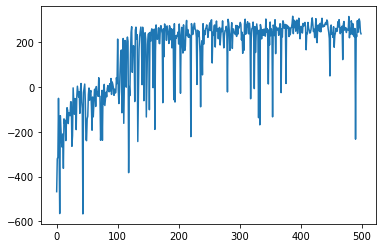

In [ ]:
plt.plot(scores)

## Running after finishing Training phase

In [ ]:
    env = gym.make('LunarLander-v2')
    lr = 0.0005
    n_games = 500
    agent = Agent(gamma=0.99, epsilon=0.0, alpha=lr, input_dims=8,
                  n_actions=4, mem_size=1000000, batch_size=64, epsilon_end=0.0)

    agent.load_model()

In [ ]:
observation = env.reset()
print(state)
img = plt.imshow(env.render('rgb_array'))
score = 0
done = False
step_num = 0
while not done:
     action = agent.choose_action(observation)
     continuous_action = action_combos[action]
     observation_, reward, done, info = env.step(continuous_action)
     score += reward

     display.clear_output(wait=True)
     img.set_data(env.render('rgb_array'))
     plt.axis('off')
     display.display(plt.gcf())
display.clear_output(wait=True)


Based on https://github.com/philtabor/Youtube-Code-Repository/blob/master/ReinforcementLearning/DeepQLearning/simple_dqn_keras.py